In [34]:
from contextlib import AsyncExitStack
from pydantic import BaseModel
from pydantic_ai import Agent, ImageUrl, BinaryContent
from pydantic_graph import End
from rich import console
from pathlib import Path
import numpy as np
import dotenv
import cv2
import matplotlib.pyplot as plt
from typing import Literal

In [2]:
dotenv.load_dotenv()

True

In [126]:
class PointPrompt(BaseModel):
    x: int
    y: int
    label: Literal['pos', 'neg']
    reason: str


class ListPointPrompt(BaseModel):
    points: list[PointPrompt]
    strategy: str


agent = Agent(
    model='google-gla:gemini-2.5-pro',
    # model='anthropic:claude-sonnet-4-20250514',
    output_type=ListPointPrompt,
    instructions=(
        '당신은 이미지 세그멘테이션을 위한 오토 라벨링을 수행하는 모델입니다.\n'
        'Segment Anything 모델을 사용하여 라벨링을 수행하기 때문에 당신이 할 일은'
        '이미지 라벨링에 적절한 Segment Anything 모델의 프롬프트를 생성하는 것입니다.\n'
        '지금은 포인트 프롬프팅만 사용할 것이며 포인트 프롬프팅을 위한 프롬프트를 생성해주세요.\n'
        'Positive, Negative 좌표를 모두 사용할 수 있습니다.\n'
        '다른 객체와의 경계에 걸치면 부적절한 segmentation이 생성될 수 있으니 목표하는 대상의 중심에 가깝게 좌표를 선택하세요.\n'
        '반드시 1개 이상의 positive 좌표를 선택해야 합니다.\n'
        '목표하는 오브젝트 내부의 positive 좌표가 많다면 성능이 올라가지만 잘못된 positive 좌표는 성능을 크게 저해할 수 있으니 주의하세요\n'
        '객채 내부의 특징이 될만한 부분이 있다면 그 부분을 포인팅 하는 경우 해당 부분만 세그멘테이션 될 수 있으니 그런 경우에는 충분히 많은'
        '포인트를 지정해야 합니다. 예를 들어 공을 세그멘테이션 하고 싶을 때 공 안의 별 무늬 위치에 포인트를 지정하면 별 무늬만 세그멘테이션 될 위험이 있습니다.\n'
        '이 경우 별과 별 밖의 공 영역에도 포인트를 생성해야 합니다.\n'
        '잘못된 Positive라벨은 성능을 매우 저하시기 때문에 완벽하게 오브젝트 내부의 포인트라는 것을 확신할 수 있을 때만 Positive라벨을 사용하세요.\n'
        '좌표를 더 정확하게 선택할 수 있도록 좌표축과 그리드라인이 이미지에 추가되어있습니다. 그걸 기반으로 대답해줘\n'
        '한번에 한개의 오브젝트만 선택해야합니다\n'
    ),
)

In [94]:
_image = cv2.imread('./assets/YPW-381.jpg')
print(_image.shape)
_image = cv2.resize(_image, (0, 0), fx=0.4, fy=0.4)
print(_image.shape)
cv2.imwrite('./assets/YPW-381-small.webp', _image)

(2000, 3000, 3)
(800, 1200, 3)


True

In [135]:
image_path = Path('./assets/dogs.webp')

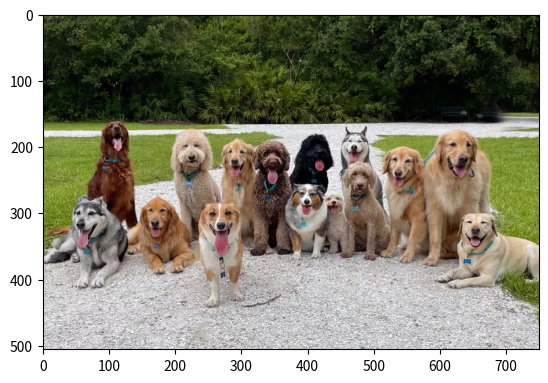

In [136]:
image = cv2.imread(str(image_path))[..., ::-1]
plt.imshow(image)
plt.show()

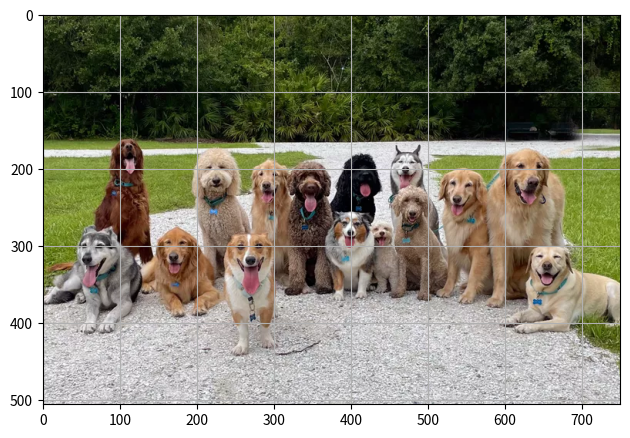

In [137]:
plt.figure(figsize=(image.shape[1]/100, image.shape[0]/100), dpi=100)
plt.imshow(image)
# plt.scatter(result.output.x, result.output.y, color='red')
plt.grid()
plt.savefig('./assets/grid_image.webp', bbox_inches='tight', dpi=100)
plt.show()

In [138]:
grid_image_path = Path('./assets/grid_image.webp')
h, w = image.shape[:2]
result = await agent.run(
    [
        (
             '검은 푸들 찾아줘\n'
            
        ),
        BinaryContent(data=grid_image_path.read_bytes(), media_type='image/webp'),
    ]
)

result

AgentRunResult(output=ListPointPrompt(points=[PointPrompt(x=425, y=300, label='pos', reason='검은 푸들의 몸 중앙입니다.')], strategy='검은 푸들의 몸 중앙에 positive point를 설정하여 다른 강아지들과 구분될 수 있도록 합니다.'))

검은 푸들의 몸 중앙에 positive point를 설정하여 다른 강아지들과 구분될 수 있도록 합니다.


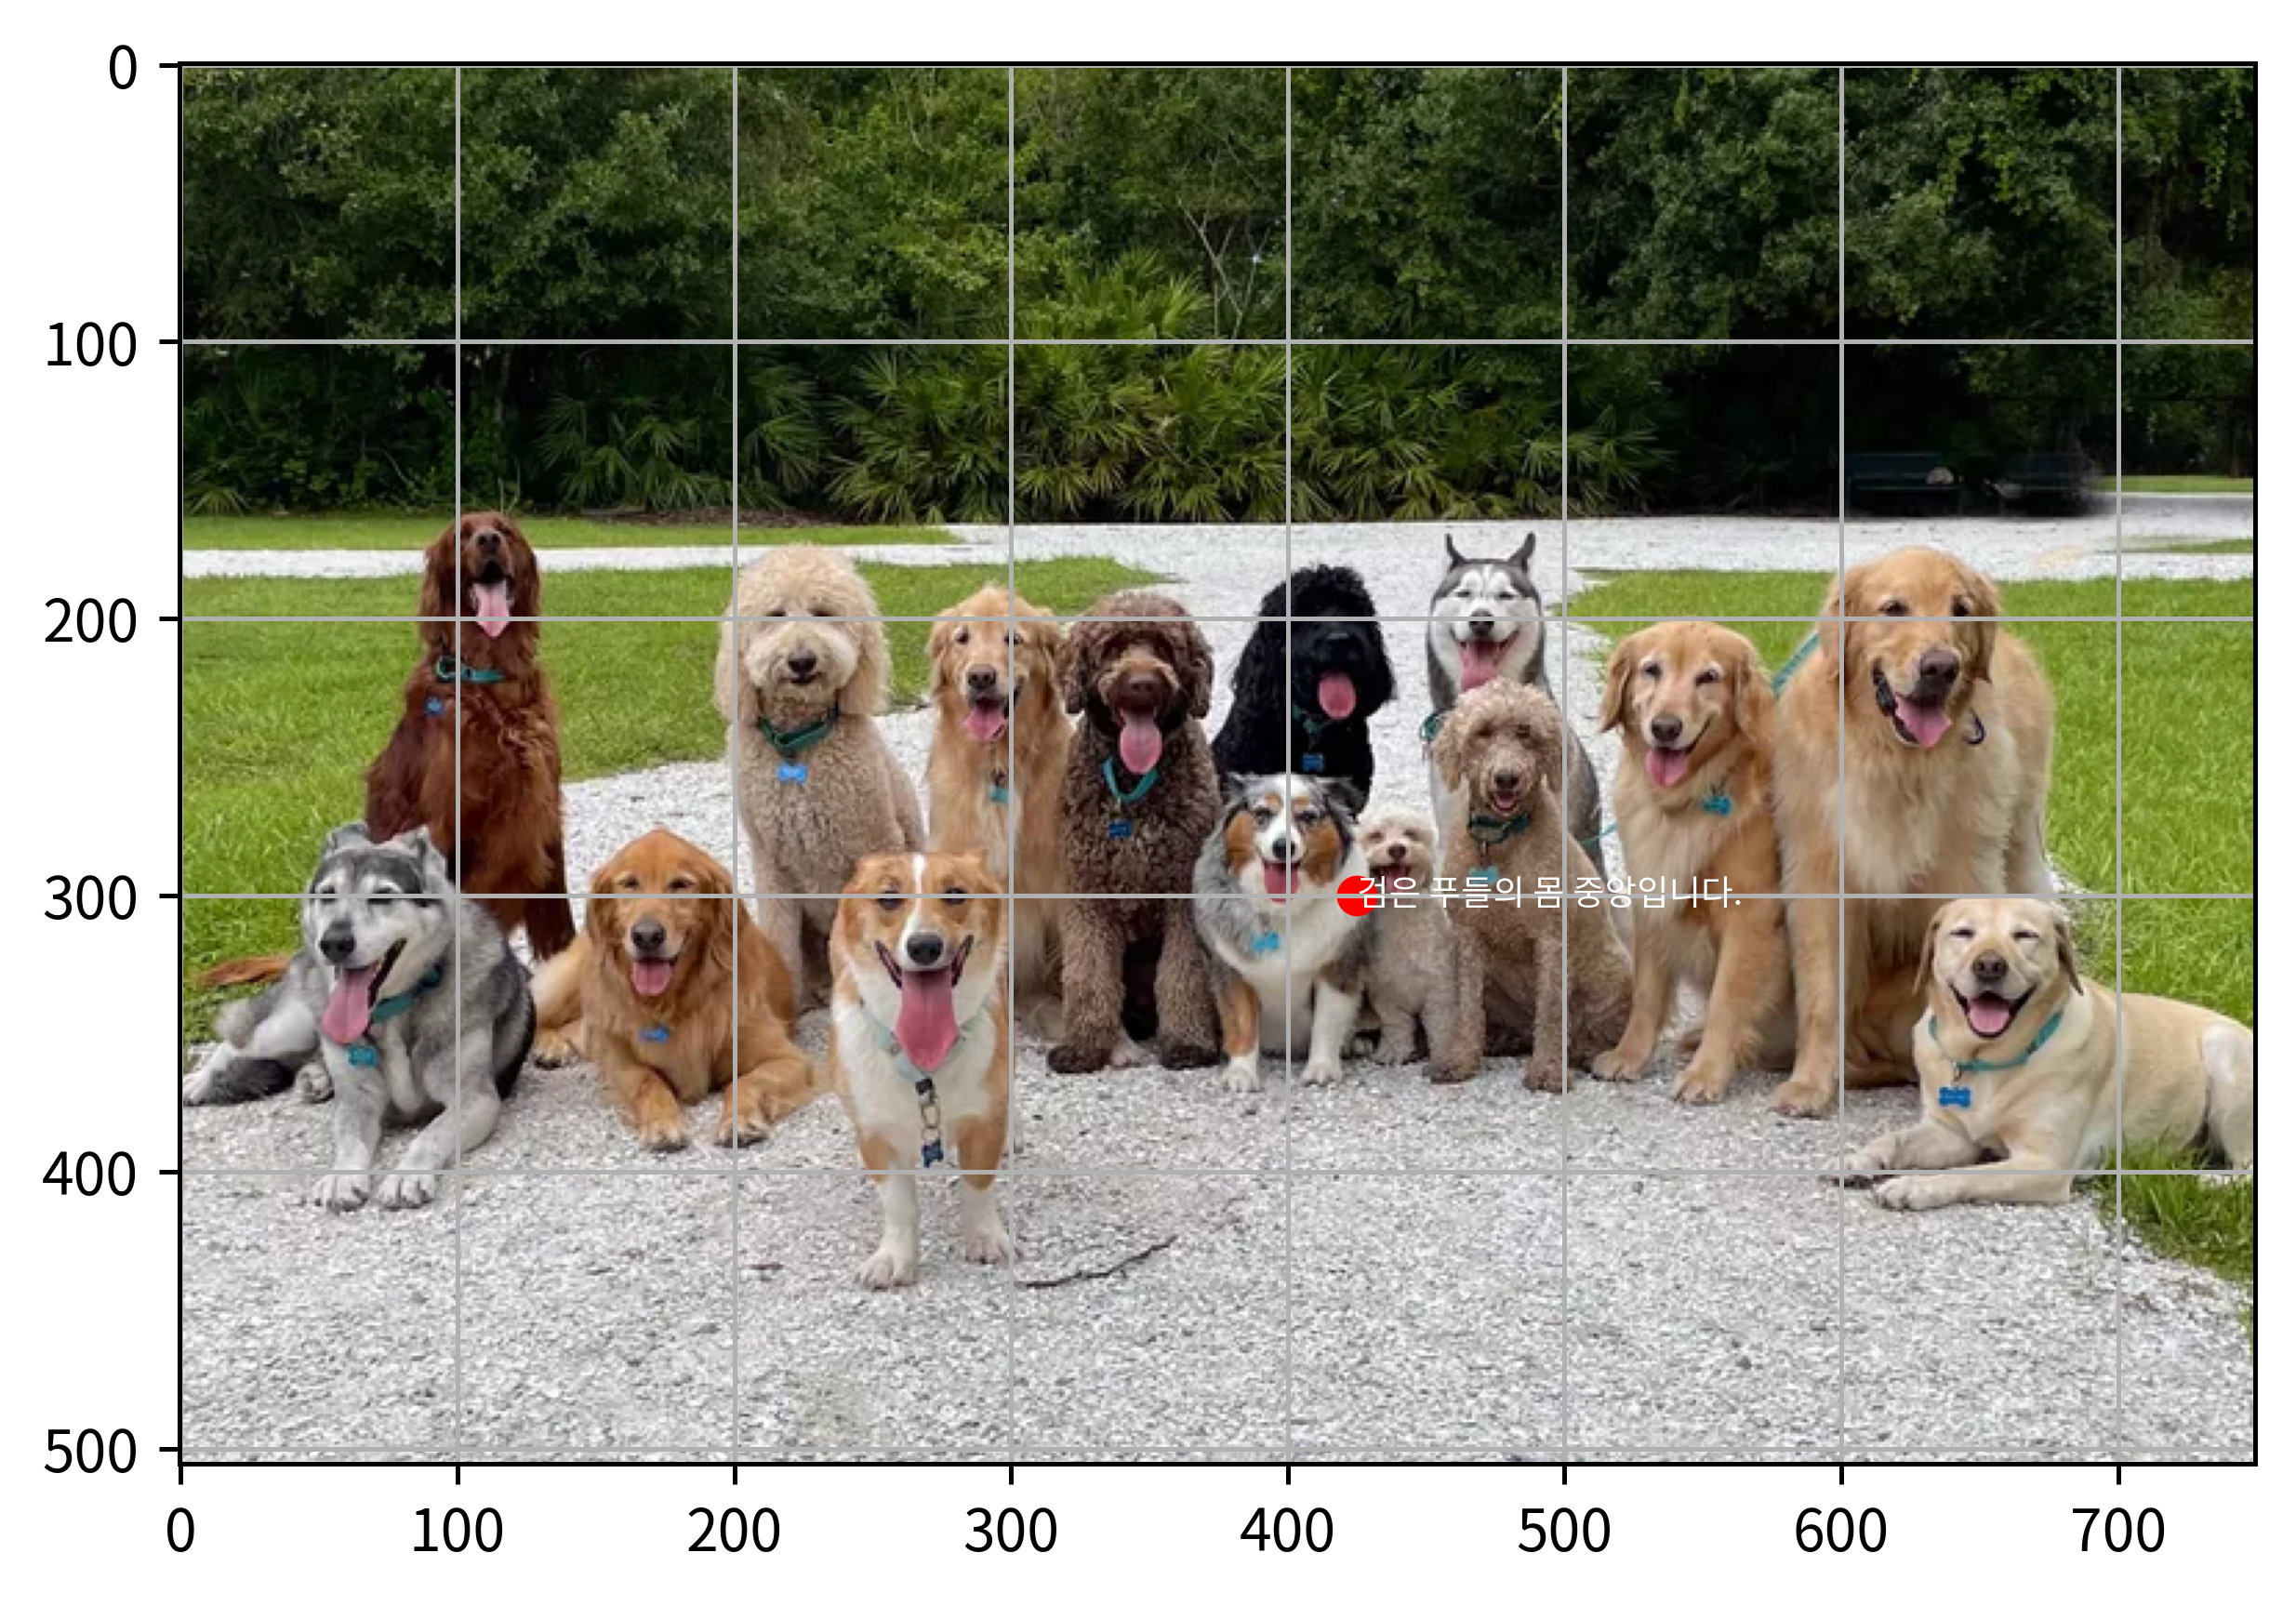

In [139]:
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
plt.figure(dpi=450)
plt.imshow(image)
print(result.output.strategy)
for point in result.output.points:
    plt.scatter(point.x, point.y, color='red' if point.label == 'pos' else 'blue')
    plt.text(point.x, point.y, point.reason, fontsize=6, ha='left', va='center', fontdict=dict(color='white'))
plt.grid()
plt.show()